In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
data_location = '/home/souvik/GitLab/ML/DATA/celebrity-faces-dataset/'

In [4]:
from matplotlib.image import imread
import seaborn as sns

In [5]:
import shutil

In [6]:
celeb_list = os.listdir(data_location)

In [6]:
os.mkdir(os.path.join(data_location, 'test'))
os.mkdir(os.path.join(data_location, 'train'))

FileExistsError: [Errno 17] File exists: '/home/souvik/GitLab/ML/DATA/celebrity-faces-dataset/test'

In [7]:
for f in ['test', 'train']:
    for celeb in celeb_list:
        os.mkdir(os.path.join(data_location, f, celeb))

In [8]:
train = 0.8

In [9]:
import random

Organize the pictures into train and test splits

In [10]:
for celeb in celeb_list:
    pics = os.listdir(os.path.join(data_location, celeb))
    # print(len(pics))
    rand_list = random.sample(pics, int(len(pics)*0.8))
    # print(rand_list)

    for pic in pics:
        if pic in rand_list:
            shutil.move(os.path.join(data_location,celeb, pic), os.path.join(data_location,'train', celeb, pic))
        else:
            shutil.move(os.path.join(data_location,celeb, pic), os.path.join(data_location,'test', celeb, pic))
    
    os.rmdir(os.path.join(data_location,celeb))

In [7]:
train_set = os.path.join(data_location, 'train')
test_set = os.path.join(data_location, 'test')

In [8]:
x = []
y = []
val_max = []
val_min = []

In [9]:
for celeb in os.listdir(os.path.join(train_set)):
    for image in os.listdir(os.path.join(train_set,celeb)):
        img = imread(os.path.join(train_set, celeb, image))
        val_max.append(img.max())
        val_min.append(img.min())
        dim1, dim2, _ = img.shape
        x.append(dim1)
        y.append(dim2)

In [10]:
np.mean(x), np.mean(y), max(val_max), min(val_min)

(494.97157816005983, 453.97456993268514, 255, 0)

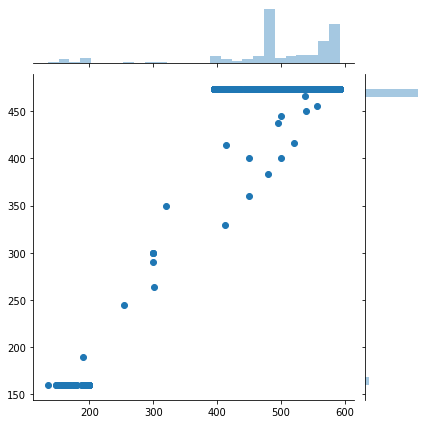

In [11]:
sns.jointplot(x, y)

In [72]:
img_shape = (300, 300, 3)

In [73]:
kernel_size=(4,4)

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
image_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=5, # rotate the image 5 degrees
                              #  width_shift_range=0.05, # Shift the pic width by a max of 5%
                              #  height_shift_range=0.05, # Shift the pic height by a max of 5%
                            #    rescale=1/255, # Rescale the image by normalzing it.
                            #    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                              #  fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                              )

NameError: name 'ImageDataGenerator' is not defined

In [76]:
image_gen.flow_from_directory(train_set)

Found 1337 images belonging to 17 classes.


In [77]:
image_gen.flow_from_directory(test_set)

Found 360 images belonging to 17 classes.


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [79]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel_size,input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=kernel_size,input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel_size,input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=kernel_size,input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=kernel_size,input_shape=img_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Flatten())


model.add(Dense(256))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid

model.add(Dense(17, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [80]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [81]:
batch_size = 64

In [82]:
train_image_gen = image_gen.flow_from_directory(train_set,
                                               target_size=img_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 1337 images belonging to 17 classes.


In [83]:
train_image_gen.class_indices

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

In [84]:
test_image_gen = image_gen.flow_from_directory(test_set,
                                               target_size=img_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 360 images belonging to 17 classes.


In [85]:
results = model.fit_generator(train_image_gen,epochs=100,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/100
21/21 [==============================] - 163s 8s/step - loss: 2.8300 - accuracy: 0.1017 - val_loss: 2.8118 - val_accuracy: 0.1111
Epoch 2/100
21/21 [==============================] - 162s 8s/step - loss: 2.8235 - accuracy: 0.1070 - val_loss: 2.8238 - val_accuracy: 0.1111
Epoch 3/100
21/21 [==============================] - 162s 8s/step - loss: 2.7970 - accuracy: 0.1182 - val_loss: 2.7582 - val_accuracy: 0.1111
Epoch 4/100
21/21 [==============================] - 158s 8s/step - loss: 2.7077 - accuracy: 0.1331 - val_loss: 2.6847 - val_accuracy: 0.1528
Epoch 5/100
21/21 [==============================] - 138s 7s/step - loss: 2.5847 - accuracy: 0.1429 - val_loss: 2.5639 - val_accuracy: 0.1917
Epoch 6/100
21/21 [==============================] - 138s 7s/step - loss: 2.5000 - accuracy: 0.1788 - val_loss: 2.4702 - val_accuracy: 0.1778
Epoch 7/100
21/21 [==============================] - 138s 7s/step - loss: 2.3526 - accuracy: 0.2124 - val_loss: 2.4030 - val_accuracy: 0.2056
Epoch 

In [86]:
metrics = pd.DataFrame(model.history.history)

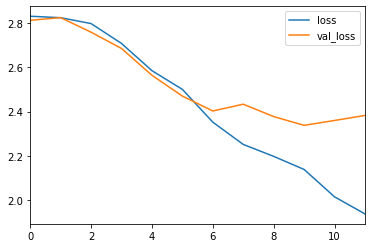

In [87]:
metrics[['loss', 'val_loss']].plot()

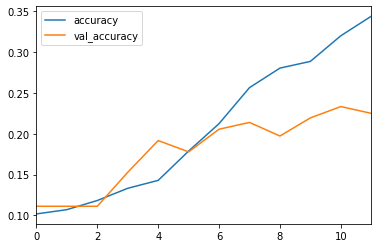

In [88]:
metrics[['accuracy', 'val_accuracy']].plot()

In [89]:
model.evaluate_generator(test_image_gen)

[2.390018622080485, 0.24166666]

In [90]:
pred = model.predict_generator(test_image_gen)

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_image_gen.classes, pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.17      0.05      0.08        20
           1       0.07      0.05      0.06        20
           2       0.12      0.10      0.11        20
           3       0.22      0.10      0.14        20
           4       0.11      0.05      0.07        20
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        20
           7       0.06      0.05      0.06        20
           8       0.05      0.10      0.06        20
           9       0.25      0.10      0.14        20
          10       0.08      0.20      0.11        20
          11       0.20      0.05      0.08        20
          12       0.00      0.00      0.00        20
          13       0.15      0.25      0.19        40
          14       0.12      0.15      0.13        20
          15       0.10      0.20      0.13        20
          16       0.14      0.05      0.07        20

    accuracy              

In [92]:
test_image_gen

In [93]:
pred.argmax(axis=1)

array([12, 15, 13,  4, 10, 10,  6, 12, 13, 16,  8,  8, 10,  8, 15, 13, 13,
        2, 13,  0, 12,  7, 13,  7,  8,  8,  9, 10, 10, 13, 10,  9,  2,  2,
       15, 13,  1,  8,  8, 14,  2,  2, 12, 15, 13,  4, 16, 14, 12, 10, 12,
        1,  1, 10, 15, 13,  3,  8, 13,  6, 14,  8,  4, 10,  7, 12, 10,  9,
       12,  8, 10, 13, 13, 12,  8, 10,  3,  7,  3,  6, 14,  5, 15, 15,  8,
       15, 16,  7,  0, 10, 10,  0, 13, 11,  5,  5, 16,  4, 15, 15, 13, 10,
        8, 13, 13, 12,  8,  1,  1,  2,  8, 10,  8, 10, 10,  8,  3, 13, 13,
       14,  2, 13,  2,  4, 13,  1,  1, 12, 13, 13,  7,  3,  7, 15,  5, 10,
       13, 13, 15, 14,  7,  2,  5, 14, 15,  3, 13, 14, 15,  1, 13, 10,  8,
       10, 14,  8, 10, 10, 14, 15,  6,  5, 15, 10,  8, 10,  3, 13,  8,  1,
       14, 13, 10, 13, 15,  7, 10, 13, 13, 15, 13, 10,  8,  8, 15, 13, 12,
       10,  9,  0, 13,  9, 15,  8,  8, 13, 13,  5, 15, 15,  8, 10, 10,  8,
        2,  6, 13, 13, 14, 10,  8, 15, 13, 14, 10,  2, 15,  2,  8, 13, 13,
       13,  7,  9, 15, 15

In [94]:
pred = pred.argmax(axis=1).reshape((360,1))

In [95]:
pred.shape

(360, 1)

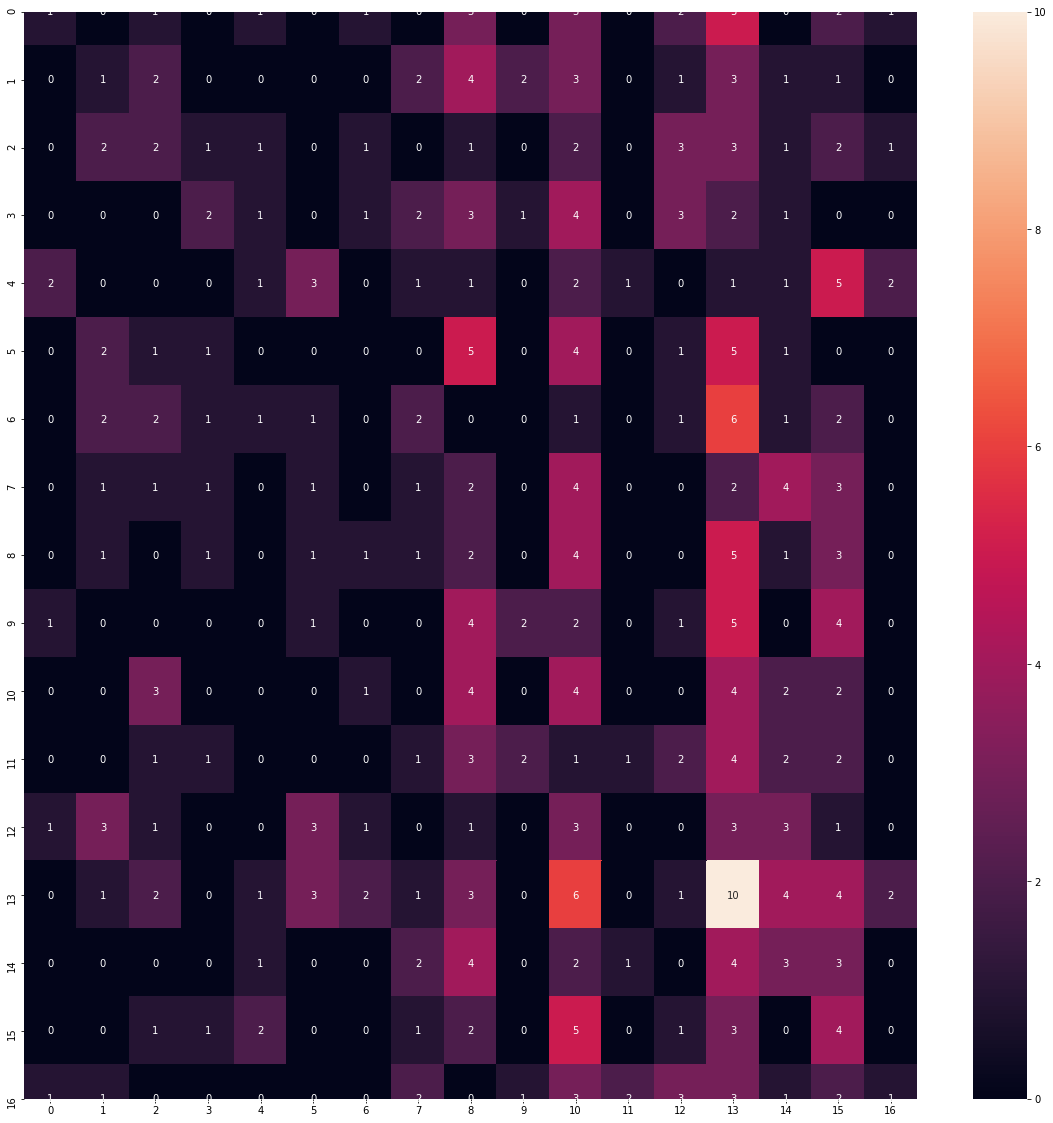

In [96]:
plt.figure(figsize =(20, 20))
sns.heatmap(confusion_matrix(test_image_gen.classes, pred), annot=True)

In [292]:
train_image_gen.class_indices

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

In [97]:
from tensorflow.keras.preprocessing import image

In [115]:
my_image = image.load_img('/home/souvik/GitLab/ML/DATA/celebrity-faces-dataset/test/Leonardo DiCaprio/008_35daa4bc.jpg', target_size=(300, 300))

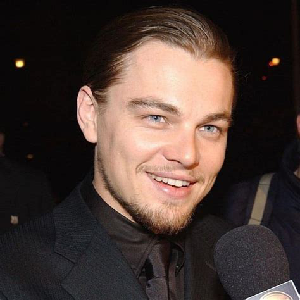

In [116]:
my_image

In [117]:
my_image_arr = image.img_to_array(my_image)

In [118]:
my_image_arr = my_image_arr.reshape((1, 300, 300, 3))

In [119]:
model.predict_classes(my_image_arr)

array([13])